<h1 align="center"><font face = "Times New Roman" size = "80">H.264 Video Compression</font></h1>
<h2 align="center"><font face = "Times New Roman" size = ""> Information theory and coding</font></h2>
<h3 align="center"><font face = "Times New Roman"> Fall 2019</font></h3>
<h5 align="center"><font face = "Times New Roman"">Alaa Mohamed Roshdy&nbsp 201600031</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Adham Mahrous&nbsp 201601078</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Mostafa Hamed&nbsp 201600236</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Kasem Saber&nbsp 201601144</font></h5>




---



In [1]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import Video # To display the video in the notebook
import numpy as np

In [2]:
import julia 
import Encoder as E
jl = julia.Julia()
jl.include('bac.jl')
jl.include('motion_estimation.jl')
path="mountain.mp4"
predictedPerRef=3 
no_frames = 5
Resolution=1
vid_frame=E.get_video_frames(path,no_frames,Resolution)
vid_frame=E.interlace_comp_frames(vid_frame)
ref_frames=vid_frame[::predictedPerRef]
n_predicted_frames = no_frames - int(np.ceil(len(vid_frame)/predictedPerRef))
residual_frames_y = np.zeros((n_predicted_frames, vid_frame[0][0].shape[0], vid_frame[0][0].shape[1]), dtype = int)
residual_frames_cb = np.zeros((n_predicted_frames, vid_frame[0][1].shape[0], vid_frame[0][1].shape[1]), dtype = int)
residual_frames_cr= np.zeros((n_predicted_frames, vid_frame[0][2].shape[0], vid_frame[0][2].shape[1]), dtype = int)

vid_mv = np.zeros((n_predicted_frames, int(vid_frame[0][0].shape[0]/16), int(vid_frame[0][0].shape[1]/16), 2), dtype = int)
c=1
for j in range(0,int(np.ceil(len(vid_frame)/predictedPerRef))):

    #Reshaping the reference frames to use in the coming blocks
    im_ref_y,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))
    im_ref_cb,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][1],8),8)
    im_ref_cr,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][2],8),8)


    for i in range(0,predictedPerRef-1):
        #print(ref_frames[j][0])
        #Reshaping the current frame 
        current_im_blocks, nrows, ncols = E.get_sub_images(E.reshape_image(vid_frame[c][0]))

        #Motion estimation 
        mv = jl.motion_estimation_to_all(ref_frames[j][0], current_im_blocks, nrows, ncols)
        print(j)

        #Motion Compensation
        p_image_y = E.predict(im_ref_y,mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1],16)
        mv_cb=np.zeros(mv.shape,dtype=int)
        for x in range(mv.shape[0]):
            for z in range(mv.shape[1]):
                mv_cb[x][z][0]=np.int(mv[x][z][0]/2)
                mv_cb[x][z][1]=np.int(mv[x][z][1]/2)

        p_image_cb=E.predict(im_ref_cb,mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1],8)
        p_image_cr=E.predict(im_ref_cr,mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1],8)

        #Calculating the residuals
        res_index = int(c - np.ceil(j/predictedPerRef) - 1)
        residual_frames_y[res_index]=E.residual(vid_frame[c][0],p_image_y)
        residual_frames_cb[res_index]=E.residual(vid_frame[c][1],p_image_cb)
        residual_frames_cr[res_index]=E.residual(vid_frame[c][2],p_image_cr)
        
        vid_mv[res_index] = mv
        c+=1
        if(c>len(vid_frame)-1):
            break
    c+=1

0
0
1


In [4]:
residual_frames_y[1].mean()

-0.3327690972222222

In [5]:
jl.include('binarize.jl')

<PyCall.jlwrap debinarize_ref_frames>

In [6]:
jl.include('bac.jl')

<PyCall.jlwrap decode_step>

In [7]:
data1 = jl.binarize_mv(vid_mv)

In [7]:
len(data1)

113448

In [9]:
data2 = jl.binarize_res((quantized_coeff_y,quantized_coeff_cb,quantized_coeff_cr))

In [10]:
len(data1) + len(data2)

17097592

In [11]:
data3 = jl.binarize_ref_frames(ref_frames)

In [12]:
len(data3) + len(data1) + len(data2)

33686392

In [13]:
v = np.hstack((data1,data2,data3))
v.shape

(33686392,)

In [14]:
enc = jl.bitstream_bac_encode(v)

In [15]:
len(enc)

33684736

In [16]:
denc = jl.bitstream_bac_decode(enc)

In [17]:
len(denc)

33686392

In [18]:
(denc == v).mean()

1.0

In [75]:
v = data1

In [55]:
jl.include('bin_and_bac.jl')

<PyCall.jlwrap decode_bin_bac>

In [19]:
#del ref_frames
del p_image_cb, p_image_cr

In [8]:
quantized_coeff_y = []
quantized_coeff_cb = []
quantized_coeff_cr = []
for j in range(0,n_predicted_frames):
    quantized_coeff_y.append(E.spatial_model(residual_frames_y[j], 16))
    
    quantized_coeff_cb.append(E.spatial_model(residual_frames_cb[j], 8))
    
    quantized_coeff_cr.append(E.spatial_model(residual_frames_cr[j], 8))

In [23]:
data = jl.encode_bin_bac(vid_mv, predictedPerRef, no_frames, (quantized_coeff_y,quantized_coeff_cb,quantized_coeff_cr), ref_frames)

In [56]:
vid_mv, residuals, ref_frames = jl.decode_bin_bac(data)

RuntimeError: Julia exception: AssertionError: pos == length(binarized)
Stacktrace:
 [1] decode_bin_bac(::Array{Bool,1}) at /home/mmahrous/mnt/NULL/Learning/Semesters/8-Fall 2019/CIE 425 - Information Theory & Coding/Projects/H.264-Video-Compression/bin_and_bac.jl:28
 [2] #invokelatest#1 at ./essentials.jl:790 [inlined]
 [3] invokelatest(::Any, ::Any) at ./essentials.jl:789
 [4] _pyjlwrap_call(::Function, ::Ptr{PyCall.PyObject_struct}, ::Ptr{PyCall.PyObject_struct}) at /home/mmahrous/.julia/packages/PyCall/ttONZ/src/callback.jl:28
 [5] pyjlwrap_call(::Ptr{PyCall.PyObject_struct}, ::Ptr{PyCall.PyObject_struct}, ::Ptr{PyCall.PyObject_struct}) at /home/mmahrous/.julia/packages/PyCall/ttONZ/src/callback.jl:49

In [28]:
ref_frames

(array([], shape=(0, 8320, 4352), dtype=uint8),
 array([], shape=(0, 4160, 2176), dtype=uint8),
 array([], shape=(0, 4160, 2176), dtype=uint8))

In [11]:
denc = jl.bitstream_bac_decode(data)

In [12]:
len(denc)

33686472

In [29]:
denc[64+16:] == np.hstack((data1,data2,data3))

/home/mmahrous/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [ ]:
quantized_residual_y = np.zeros((n_predicted_frames, vid_frame[0][0].shape[0], vid_frame[0][0].shape[1]), dtype = int)
quantized_residual_cb = np.zeros((n_predicted_frames, vid_frame[0][1].shape[0], vid_frame[0][1].shape[1]), dtype = int)
quantized_residual_cr= np.zeros((n_predicted_frames, vid_frame[0][2].shape[0], vid_frame[0][2].shape[1]), dtype = int)
for j in range(0,predictedPerRef-1):
    quantized_residual_y[j] = E.spatial_inverse_model(quantized_coeff_y[j], nrows, ncols, 16)

    quantized_residual_cb[j] =  E.spatial_inverse_model(quantized_coeff_cb[j], nrows, ncols, 8)

    quantized_residual_cr[j] = E.spatial_inverse_model(quantized_coeff_cr[j], nrows, ncols, 8) 

In [157]:
    Reconstruced_frames=[]
    c=0
    for j in range(0,np.int(no_frames/predictedPerRef)):
        Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(ref_frames[j])))

        #Reshaping the reference frames to use in the coming blocks
        im_ref_y,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))
        im_ref_cb,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][1],8),8)
        im_ref_cr,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][2],8),8)
        for i in range(0,predictedPerRef-1):
            #inverse spatial
            #residual_blocks, n_rows, n_cols = E.spatial_inverse_model(vid_residuals[c])
            #residual_frame = E.get_reconstructed_image(residual_blocks, n_rows, n_cols)
            mv=vid_mv[c]
            for i in range(mv.shape[0]):
                for j in range(mv.shape[1]):
                    mv_cb[i][j][0]=np.int(mv[i][j][0]/2)
                    mv_cb[i][j][1]=np.int(mv[i][j][1]/2)
            #getting the predicted image
            p_image_y = E.predict(im_ref_y, mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1])
            p_image_cb = E.predict(im_ref_cb, mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1], 8)
            p_image_cr = E.predict(im_ref_cr, mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1], 8)
            #adding the residuals to get the reconstructed image
            
            Reconstructed_y = p_image_y + quantized_residual_y[c]
            Reconstructed_cb = p_image_cb + quantized_residual_cb[c]
            Reconstructed_cr = p_image_cr + quantized_residual_cr[c]

            Reconstructed_interlaced=[Reconstructed_y,Reconstructed_cb,Reconstructed_cr]
            Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(Reconstructed_interlaced)))
            c+=1

Text(0.5, 1.0, 'last predicted frame')

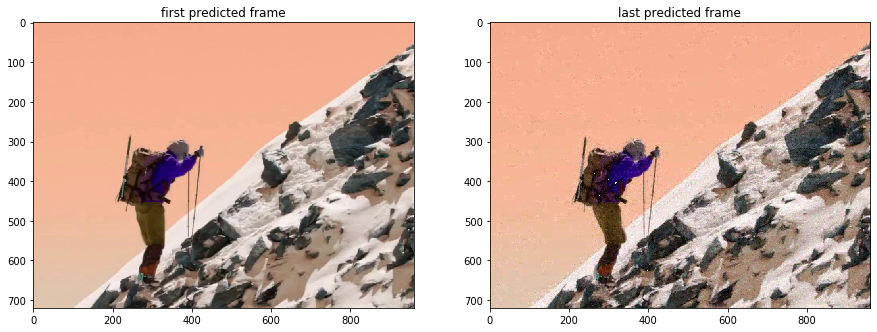

In [159]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,15))

ax1.imshow(Reconstruced_frames[0])
ax1.set_title("first predicted frame")


ax2.imshow(Reconstruced_frames[2])
ax2.set_title("last predicted frame")

In [52]:
Reconstruced_frames[0].shape

(720, 960, 3)

In [26]:
cv2.imshow('image',Reconstruced_frames[2])
cv2.waitKey(0)

cv2.destroyAllWindows()